### **导入库**

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

In [251]:
# 过滤警告
import warnings
warnings.filterwarnings("ignore")

# plt中文显示问题
import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负

# sns中文显示
sns.set(font="simhei")

### **导入数据**

In [252]:
# 导入数据
retail =  pd.read_csv('拼多多项目-RFM原始数据Python.csv',encoding='GBK')
retail.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,所在省市,CustomerID,金额
0,537899,22328,ROUND SNACK BOXES SET OF 4 FRUITS,1488,01-12-2010 08:26,2.55,安徽,17850.0,3794.4
1,579498,23084,RABBIT NIGHT LIGHT,2040,01-12-2010 08:26,1.79,安徽,17850.0,3651.6
2,572869,23084,RABBIT NIGHT LIGHT,960,01-12-2010 08:26,1.79,安徽,17850.0,1718.4


### **查看数据**

In [253]:
print('数据形状：')
print(retail.shape)
print('-'*50)
print('数据描述性统计：')
print(retail.describe())
print('-'*50)
print('数据信息：')
print(retail.info())

数据形状：
(541909, 9)
--------------------------------------------------
数据描述性统计：
            Quantity      UnitPrice     CustomerID             金额
count  541909.000000  541909.000000  406829.000000  541909.000000
mean        9.552250       4.611114   15287.690570      17.987795
std       218.081158      96.759853    1713.600303     378.810824
min    -80995.000000  -11062.060000   12346.000000 -168469.600000
25%         1.000000       1.250000   13953.000000       3.400000
50%         3.000000       2.080000   15152.000000       9.750000
75%        10.000000       4.130000   16791.000000      17.400000
max     80995.000000   38970.000000   18287.000000  168469.600000
--------------------------------------------------
数据信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-nul

### **缺失值处理**

In [254]:
# 查看缺失值
retail.isnull().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
所在省市           0.000000
CustomerID     0.249267
金额             0.000000
dtype: float64

In [255]:
# 对于占比较小的缺失值可以选择删除
retail = retail.dropna()

### **数据格式规整**

In [256]:
# 将客户ID转换为字符串类型
retail['CustomerID'] = retail['CustomerID'].astype(str)
# 将发票日期转换为时间类型
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

### **构建聚类特征**

In [257]:
# 添加新特征——交易总额
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
# 求每个用户总消费额
RFM_M = retail.groupby('CustomerID')['Amount'].sum().reset_index()
RFM_M.head(3)

,CustomerID,Amount
0,12346.0,51.00
1,12347.0,4626.49
2,12348.0,941.31


In [258]:
# 添加新特征——购买频率
RFM_F = retail.groupby('CustomerID')['InvoiceNo'].count().reset_index()
RFM_F.head(3)

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31


In [259]:
# 添加新特征——最近消费日期
# 计算最大交易日期得出最后交易日期
last_date = max(retail['InvoiceDate'])
# 计算最后交易日期和当前交易日期之间的差异
retail['Diff'] = last_date - retail['InvoiceDate']
# 计算最后交易日期
RFM_R = retail.groupby('CustomerID')['Diff'].min().reset_index()
RFM_R['Diff'] = RFM_R['Diff'].dt.days
RFM_R.head(3)

,CustomerID,Diff
0,12346.0,326
1,12347.0,40
2,12348.0,76


In [260]:
# 将特征组合成新的RFM数据集
RFM = pd.merge(RFM_R,RFM_F,on='CustomerID',how='inner')
RFM = pd.merge(RFM,RFM_M,on='CustomerID',how='inner')
RFM.columns = ['CustomerID', 'R','F','M']
RFM

,CustomerID,R,F,M
0,12346.0,326,2,51.00
1,12347.0,40,182,4626.49
2,12348.0,76,31,941.31
3,12349.0,19,73,30.66
4,12350.0,311,17,353.60
...,...,...,...,...
4367,18280.0,160,10,177.00
4368,18281.0,4,7,70.00
4369,18282.0,93,13,401.55
4370,18283.0,10,756,8234.51


### **探索性数据分析**

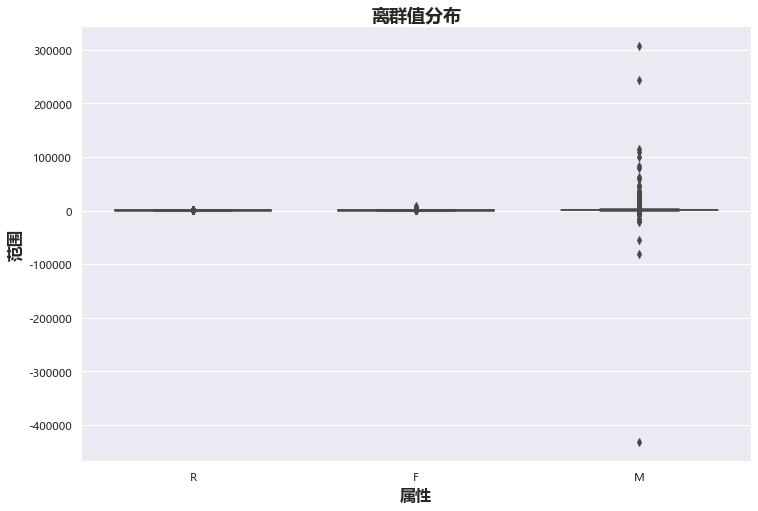

In [261]:
sns.set_style('darkgrid')
sns.set(font="Microsoft Yahei")
plt.rcParams['figure.figsize'] = [12,8]
sns.boxplot(data=RFM[['R','F','M']],orient='v',
            palette='Set1',
            saturation=1,
            whis=1.5,
            width=0.7
            )
plt.xlabel('属性',fontsize = 16,fontweight = 'bold')
plt.ylabel('范围',fontsize = 16,fontweight = 'bold')
plt.title('离群值分布',fontsize = 18,fontweight = 'bold');

### **离群值处理**

In [262]:
"""
异常值/离群值检验有三种方法，分别是：
1.描述性统计方法查看
2.三倍标准差法过滤
3.借助箱型图，以上四分位±1.5倍四分位为边界判断

另外需要注意的是，在实际业务中，异常值需要根据实际业务
情况进行处理。对于本数据集的超大数据可能代表着高消费客户，
所以不能轻易删除。
"""

# 下面为其中一种处理方式


'\n异常值/离群值检验有三种方法，分别是：\n1.描述性统计方法查看\n2.三倍标准差法过滤\n3.借助箱型图，以上四分位±1.5倍四分位为边界判断\n\n另外需要注意的是，在实际业务中，异常值需要根据实际业务\n情况进行处理。对于本数据集的超大数据可能代表着高消费客户，\n所以不能轻易删除。\n'

In [263]:
# 移除M列离群值
Q1 = RFM.M.quantile(0.05)
Q2 = RFM.M.quantile(0.95)
IQR = Q2-Q1
RFM = RFM[(RFM.M>=Q1-1.5*IQR)&(RFM.M<=Q2+1.5*IQR)]

# 移除R列离群值
Q1 = RFM.R.quantile(0.05)
Q2 = RFM.R.quantile(0.95)
IQR = Q2-Q1
RFM = RFM[(RFM.R>=Q1-1.5*IQR)&(RFM.R<=Q2+1.5*IQR)]

# 移除F列离群值
Q1 = RFM.F.quantile(0.05)
Q2 = RFM.F.quantile(0.95)
IQR = Q2-Q1
RFM = RFM[(RFM.F>=Q1-1.5*IQR)&(RFM.F<=Q2+1.5*IQR)]

### **模型构建**

In [264]:
# 标准化
train = RFM[['R','F','M']]
train = StandardScaler().fit_transform(train)
train

array([[ 1.98597938, -0.74474135, -0.5346345 ],
       [-0.54529644,  1.01753679,  1.7841037 ],
       [-0.22667431, -0.46081876, -0.08344877],
       ...,
       [-0.86391857, -0.69578918, -0.5250058 ],
       [-0.07621386, -0.63704657, -0.35698497],
       [-0.89932103, -0.07899183, -0.32949249]])

In [265]:
model = KMeans(algorithm='lloyd',
               n_clusters=8,
               max_iter=1000,
               random_state=2022,
               verbose=True
               )
model.fit(train).cluster_centers_

Initialization complete
Iteration 0, inertia 2558.8318135222194.
Iteration 1, inertia 2192.050737215556.
Iteration 2, inertia 2140.4449007297694.
Iteration 3, inertia 2115.9437208249706.
Iteration 4, inertia 2084.0510050211906.
Iteration 5, inertia 2059.5045104958394.
Iteration 6, inertia 2039.6441136403685.
Iteration 7, inertia 2025.7672283955335.
Iteration 8, inertia 2012.294432164115.
Iteration 9, inertia 1993.0458421746744.
Iteration 10, inertia 1981.5862094336676.
Iteration 11, inertia 1976.7713150155066.
Iteration 12, inertia 1973.7927993933058.
Iteration 13, inertia 1971.9932043928193.
Iteration 14, inertia 1971.0187441732385.
Iteration 15, inertia 1969.9096997346953.
Iteration 16, inertia 1969.5443594667313.
Iteration 17, inertia 1969.2068127541534.
Iteration 18, inertia 1968.909847678264.
Iteration 19, inertia 1968.2134314007897.
Iteration 20, inertia 1967.837983905099.
Iteration 21, inertia 1967.4362335125504.
Iteration 22, inertia 1966.7121719940237.
Iteration 23, inertia 19

array([[-0.55640408,  0.55658688,  0.29199215],
       [ 0.48642461, -0.47415297, -0.36023497],
       [-0.71122003,  4.37317994,  3.59988196],
       [-0.54736873, -0.38738486, -0.43113218],
       [ 1.63109091, -0.51366547, -0.29432556],
       [-0.63006195,  2.05953453,  1.36032362],
       [-0.30530861,  0.83566065,  3.98459184],
       [ 4.27841151, -0.5950293 ,  0.17651814]])

### **模型解释**

In [266]:
# 查看聚类类别标签
model.labels_

array([4, 5, 3, ..., 3, 3, 3])

In [267]:
print(f'第一类用户数量：{(model.labels_==0).sum()}')
print(f'第二类用户数量：{(model.labels_==1).sum()}')
print(f'第三类用户数量：{(model.labels_==2).sum()}')
print(f'第四类用户数量：{(model.labels_==3).sum()}')
print(f'第五类用户数量：{(model.labels_==4).sum()}')
print(f'第六类用户数量：{(model.labels_==5).sum()}')
print(f'第七类用户数量：{(model.labels_==6).sum()}')
print(f'第八类用户数量：{(model.labels_==7).sum()}')

第一类用户数量：698
第二类用户数量：815
第三类用户数量：87
第四类用户数量：1734
第五类用户数量：543
第六类用户数量：265
第七类用户数量：78
第八类用户数量：72


In [268]:
R1 = pd.Series(model.labels_).value_counts()
R2 = pd.DataFrame(model.cluster_centers_)
Cluster_8 = pd.concat([R1, R2],axis=1)
Cluster_8.columns = ['数量','R','F','M']
Cluster_8['占比'] = round(Cluster_8['数量']/RFM.shape[0],4)
Cluster_8

,数量,R,F,M,占比
3,1734,-0.547369,-0.387385,-0.431132,0.4040
1,815,0.486425,-0.474153,-0.360235,0.1899
0,698,-0.556404,0.556587,0.291992,0.1626
4,543,1.631091,-0.513665,-0.294326,0.1265
5,265,-0.630062,2.059535,1.360324,0.0617
2,87,-0.711220,4.373180,3.599882,0.0203
6,78,-0.305309,0.835661,3.984592,0.0182
7,72,4.278412,-0.595029,0.176518,0.0168


In [269]:
"""
根据上表结果，确定聚类类别与用户类别对应关系，进行手动分类;
2---->HHH:重要价值客户
1---->HHL:一般价值客户
6---->HLH:重要发展客户
3---->HLL:一般发展客户
5---->LHH:重要保持客户
0---->LHL:一般保持客户
7---->LLH:重要挽留客户
4---->LLL:一般挽留客户
"""

Cat_of_Customer = { 2:'重要价值客户',
                    1:'一般价值客户',
                    6:"重要发展客户",
                    3:'一般发展客户',
                    5:'重要保持客户',
                    0:'一般保持客户',
                    7:'重要挽留客户',
                    4:'一般挽留客户'}
df = pd.DataFrame.from_dict(Cat_of_Customer, orient='index')
df.columns = ['用户分层']
Cluster_8 = pd.merge(Cluster_8,df,left_index=True,right_index=True) 
Cluster_8

,数量,R,F,M,占比,用户分层
3,1734,-0.547369,-0.387385,-0.431132,0.4040,一般发展客户
1,815,0.486425,-0.474153,-0.360235,0.1899,一般价值客户
0,698,-0.556404,0.556587,0.291992,0.1626,一般保持客户
4,543,1.631091,-0.513665,-0.294326,0.1265,一般挽留客户
5,265,-0.630062,2.059535,1.360324,0.0617,重要保持客户
2,87,-0.711220,4.373180,3.599882,0.0203,重要价值客户
6,78,-0.305309,0.835661,3.984592,0.0182,重要发展客户
7,72,4.278412,-0.595029,0.176518,0.0168,重要挽留客户


In [277]:
# 然后将聚类结果传入RFM表中，让结果更直观
RFM = pd.merge(RFM,df,left_index=True,right_index=True)
RFM.head(20)

,CustomerID,R,F,M,用户分层_x,用户分层_y
0,12346.0,326,2,51.00,一般保持客户,一般保持客户
1,12347.0,40,182,4626.49,一般价值客户,一般价值客户
2,12348.0,76,31,941.31,重要价值客户,重要价值客户
3,12349.0,19,73,30.66,一般发展客户,一般发展客户
4,12350.0,311,17,353.60,一般挽留客户,一般挽留客户
5,12352.0,73,95,1013.27,重要保持客户,重要保持客户
6,12353.0,204,4,47.20,重要发展客户,重要发展客户
7,12354.0,233,58,870.00,重要挽留客户,重要挽留客户
